# IMPORT

In [1]:
from transformers import pipeline
import torch
import pandas as pd
import re, unicodedata
import os
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import json

if torch.cuda.is_available():
    print("GPU disponible !")
    print(f"Nom du GPU : {torch.cuda.get_device_name(0)}")
else:
    print("GPU non disponible, utilisation du CPU.")

c:\Users\Fournier\Documents\Cours CS\fillière recherche\psychological_analysis_of_breast_cancer_patients\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU non disponible, utilisation du CPU.


# MODEL

In [2]:
classifier = pipeline("text-classification", device="cpu" ,model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

Device set to use cpu
c:\Users\Fournier\Documents\Cours CS\fillière recherche\psychological_analysis_of_breast_cancer_patients\.venv\lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [3]:
total_params = sum(p.numel() for p in classifier.model.parameters())
print(f"Nombre total de poids : {total_params}")

Nombre total de poids : 82123783


## Test model

In [10]:
# english test
classifier("I love this!")

[[{'label': 'anger', 'score': 0.004419779404997826},
  {'label': 'disgust', 'score': 0.0016119909705594182},
  {'label': 'fear', 'score': 0.00041385178337804973},
  {'label': 'joy', 'score': 0.9771687984466553},
  {'label': 'neutral', 'score': 0.005764589179307222},
  {'label': 'sadness', 'score': 0.002092391485348344},
  {'label': 'surprise', 'score': 0.008528673090040684}]]

In [11]:
classifier("All I know is I've enjoyed ""normal""food this week since being temporarily off Verzenio, and I'm loving it.  Anyone noticed that foods/drinks taste differently? I'm finding my favorite drink, water, tasting bitter, and that's disturbing." )

[[{'label': 'anger', 'score': 0.0061537777073681355},
  {'label': 'disgust', 'score': 0.9300992488861084},
  {'label': 'fear', 'score': 0.020451316609978676},
  {'label': 'joy', 'score': 0.004342163447290659},
  {'label': 'neutral', 'score': 0.015185059048235416},
  {'label': 'sadness', 'score': 0.017695654183626175},
  {'label': 'surprise', 'score': 0.0060727838426828384}]]

# IMPORT DATA

In [4]:
def load_all_csv_from_folder(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df["source_file"] = os.path.basename(file)
        df_list.append(df)
    
    big_df = pd.concat(df_list, ignore_index=True)
    return big_df

df = load_all_csv_from_folder("../data/scraped_data_in_treatment/")

In [5]:
dict_thread_conversation = df.groupby('thread_title')['comment_text'].apply(list).to_dict()
print(next(iter(dict_thread_conversation)))
print(next(iter(dict_thread_conversation.values()))[1])

%E2%80%8Bdoes Anyone Take Letrozole Femara Every Other Day
My oncologist also did not want me to take it every other day.  He wanted to put me on Tamoxifen and something else instead.  I'm looking for another oncologist.


In [6]:
def get_table_score_from_output(output_model):
    table_score = {}
    all_dico = output_model[0]
    for dico in all_dico:
        emotion = dico['label']
        table_score[emotion] =dico['score']

    return table_score

In [15]:
print(get_table_score_from_output([[{'label': 'positive', 'score': 0.12064313888549805},
  {'label': 'neutral', 'score': 0.3123035132884979},
  {'label': 'negative', 'score': 0.5670533180236816}]]))

{'positive': 0.12064313888549805, 'neutral': 0.3123035132884979, 'negative': 0.5670533180236816}


# Visualisation

In [7]:
def display_spider_graph_from_score(scores,title=None):
    labels = list(scores.keys())
    values = list(scores.values())

    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    max_value = max(scores.values())

    yticks = np.linspace(0, max_value, 5)[1:] 
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.2f}" for y in yticks])  
    ax.set_ylim(0, max_value)

    if title is not None:
        ax.set_title(title, size=14, pad=20)

    plt.show()

# Topics

In [ ]:
topics_name = "Chemotherapy - Before, During, and After"
df_topics = pd.read_csv("../data/scraped_data_in_treatment/" + topics_name + ".csv")

In [ ]:
dict_thread_conversation_one_topics = df_topics.groupby('thread_title')['comment_text'].apply(list).to_dict()
print(next(iter(dict_thread_conversation)))
print(next(iter(dict_thread_conversation.values()))[1])

In [ ]:
def get_sentiment_per_topic(dict_thread_conversation_one_topics,verbose=False,max_thread_to_use=None):
    if not max_thread_to_use:
        max_thread_to_use = len(dict_thread_conversation_one_topics.keys())
    if verbose:
        print(f"max_thread_to_use : {max_thread_to_use}")
    compteur=0
    for thread_name, conversation in dict_thread_conversation_one_topics.items():
        if compteur > max_thread_to_use-1:
            break
        for nbr_st,sentence in enumerate(conversation):
            try:
                output_one_sentence = classifier(sentence)
            except:
                # if nbr token > max token for the model
                pass
            score_one_sentence = get_table_score_from_output(output_one_sentence)
            if nbr_st==0:
                score_thread = score_one_sentence
            else:
                for emotion in score_thread.keys():
                    score_thread[emotion] += score_one_sentence[emotion]

        #normalisation
        for emotion in score_thread.keys():
            score_thread[emotion] = score_thread[emotion]/len(conversation)

        if verbose:
            print()
            print(f"\nName thread : {thread_name}")
            print(f"Score : {score_thread}")

        if compteur ==0:
            score_topic = score_thread
        else:
            for emotion in score_topic.keys():
                score_topic[emotion] += score_thread[emotion]

        compteur +=1
    
    # Final normalisation
    for emotion in score_topic.keys():
        score_topic[emotion] = score_topic[emotion]/max_thread_to_use

    return score_topic

In [ ]:
score_sentiment_per_topic = get_sentiment_per_topic(dict_thread_conversation,max_thread_to_use=None,verbose=False)
print(score_sentiment_per_topic)

In [ ]:
display_spider_graph_from_score(score_sentiment_per_topic)

# Pipeline analyze features

In [8]:
def get_emotion_per_features(dict_features_msg):
    dict_EmotionScore = {}
    for features, messages in dict_features_msg.items():
        score = 0
        if messages:
            print(f"features : {features} ; num of msg : {len(messages)}")
            for sentence in messages:
                try:
                    output_sentence = classifier(sentence)
                except:
                    # if nbr token > max token for the model
                    continue
                score_sentence = get_table_score_from_output(output_sentence)
                if score==0:
                    score = score_sentence
                else:
                    for emotion in score.keys():
                        score[emotion] += score_sentence[emotion]

            # Normalization
            if score != 0:
                for emotion in score.keys():
                    score[emotion] = score[emotion]/len(messages)

                dict_EmotionScore[features] = score

    print(f"\nAll features get : {list(dict_EmotionScore.keys())}")
    return dict_EmotionScore

# DRUG

### Find msg with drug mention

In [9]:
list_drug_breast_cancer_ref  = [
    "Abemaciclib",
    "Abraxane (Paclitaxel Albumin-stabilized Nanoparticle Formulation)",
    "Ado-Trastuzumab Emtansine",
    "Afinitor (Everolimus)",
    "Afinitor Disperz (Everolimus)",
    "Alpelisib",
    "Anastrozole",
    "Aredia (Pamidronate Disodium)",
    "Arimidex (Anastrozole)",
    "Aromasin (Exemestane)",
    "Capecitabine",
    "Capivasertib",
    "Cyclophosphamide",
    "Datroway (Datopotamab deruxtecan-dlnk)",
    "Datopotamab deruxtecan-dlnk",
    "Docetaxel",
    "Doxorubicin Hydrochloride",
    "Doxorubicin",
    "Elacestrant Dihydrochloride",
    "Ellence (Epirubicin Hydrochloride)",
    "Enhertu (Fam-Trastuzumab Deruxtecan-nxki)",
    "Epirubicin Hydrochloride",
    "Eribulin Mesylate",
    "Everolimus",
    "Exemestane",
    "5-FU (Fluorouracil Injection)",
    "Fam-Trastuzumab Deruxtecan-nxki",
    "Fareston (Toremifene)",
    "Faslodex (Fulvestrant)",
    "Femara (Letrozole)",
    "Fluorouracil Injection",
    "Fulvestrant",
    "Gemcitabine Hydrochloride",
    "Gemcitabine",
    "Gemzar (Gemcitabine Hydrochloride)",
    "Goserelin Acetate",
    "Halaven (Eribulin Mesylate)",
    "Herceptin Hylecta (Trastuzumab and Hyaluronidase-oysk)",
    "Herceptin (Trastuzumab)",
    "Ibrance (Palbociclib)",
    "Inavolisib",
    "Infugem (Gemcitabine Hydrochloride)",
    "Itovebi (Inavolisib)",
    "Ixabepilone",
    "Ixempra (Ixabepilone)",
    "Kadcyla (Ado-Trastuzumab Emtansine)",
    "Keytruda (Pembrolizumab)",
    "Kisqali (Ribociclib Succinate)",
    "Kisqali Femara Co-Pack (Ribociclib Succinate and Letrozole)",
    "Lapatinib Ditosylate",
    "Letrozole",
    "Lynparza (Olaparib)",
    "Margenza (Margetuximab-cmkb)",
    "Margetuximab-cmkb",
    "Megestrol Acetate",
    "Methotrexate Sodium",
    "Neratinib Maleate",
    "Nerlynx (Neratinib Maleate)",
    "Olaparib",
    "Orserdu (Elacestrant Dihydrochloride)",
    "Paclitaxel",
    "Paclitaxel Albumin-stabilized Nanoparticle Formulation",
    "Palbociclib",
    "Pamidronate Disodium",
    "Pembrolizumab",
    "Perjeta (Pertuzumab)",
    "Pertuzumab",
    "Pertuzumab, Trastuzumab, and Hyaluronidase-zzxf",
    "Phesgo (Pertuzumab, Trastuzumab, and Hyaluronidase-zzxf)",
    "Piqray (Alpelisib)",
    "Ribociclib Succinate",
    "Ribociclib Succinate and Letrozole",
    "Sacituzumab Govitecan-hziy",
    "Soltamox (Tamoxifen Citrate)",
    "Talazoparib Tosylate",
    "Talzenna (Talazoparib Tosylate)",
    "Tamoxifen Citrate",
    "Taxotere (Docetaxel)",
    "Tecentriq (Atezolizumab)",
    "Tepadina (Thiotepa)",
    "Thiotepa",
    "Toremifene",
    "Trastuzumab",
    "Trastuzumab and Hyaluronidase-oysk",
    "Trodelvy (Sacituzumab Govitecan-hziy)",
    "Truqap (Capivasertib)",
    "Tucatinib",
    "Tukysa (Tucatinib)",
    "Tykerb (Lapatinib Ditosylate)",
    "Verzenio (Abemaciclib)",
    "Vinblastine Sulfate",
    "Xeloda (Capecitabine)",
    "Zoladex (Goserelin Acetate)"
]

In [10]:
dict_equi_drug_name = {
    # 5-Fluorouracil
    "5 fluorouracil": "5-Fluorouracil",
    "5-FU": "5-Fluorouracil",
    "5-Flourouracil": "5-Fluorouracil",
    "FLOUROURACIL": "5-Fluorouracil",
    "FLUOROURACIL": "5-Fluorouracil",
    "Fluorouracil": "5-Fluorouracil",
    
    # Adriamycin/Doxorubicin
    "ADRIAMYCIN": "Doxorubicin",
    "Adriamycin": "Doxorubicin",
    "Adriamyicin": "Doxorubicin",
    "Adrimycin": "Doxorubicin",
    "adriamicin": "Doxorubicin",
    "adriamycin": "Doxorubicin",
    "adriamycin+cuclophosphamide": "Doxorubicin",
    "adriamycin+cyclophosphamid": "Doxorubicin",
    "adriamycin+cyclophosphamide": "Doxorubicin",
    "adrimicin+cyclophosphamide": "Doxorubicin",
    "adrimycin+cyclophosphamide": "Doxorubicin",
    "DOXORUBICIN": "Doxorubicin",
    "Doxorubicin": "Doxorubicin",
    "Doxorubicin Liposome": "Doxorubicin",
    "Doxorubicinum": "Doxorubicin",
    "doxorubicin HCL": "Doxorubicin",
    "doxorubicin+ cyclophosphamide": "Doxorubicin",
    "doxorubicin+cyclophosphamid": "Doxorubicin",
    "doxorubicine": "Doxorubicin",
    "doxorubicine cyclophosphamide tamoxifen": "Doxorubicin",
    "doxorubicine+cyclophosphamide": "Doxorubicin",
    "doxorubicine+cyclophosphamide+tamoxifen": "Doxorubicin",

    # Cyclophosphamide/Cytoxan
    "CYCLOPHOSPHAMIDE": "Cyclophosphamide",
    "Cyclophosphamide": "Cyclophosphamide",
    "Cyclophasphamide": "Cyclophosphamide",
    "Cyclophospamide": "Cyclophosphamide",
    "Cyclophosphane": "Cyclophosphamide",
    "cyclophosphamid": "Cyclophosphamide",
    "cyclophosphamide": "Cyclophosphamide",
    "cyclophosphamidum": "Cyclophosphamide",
    "CYTOXAN": "Cyclophosphamide",
    "Cyotxan": "Cyclophosphamide",
    "Cytoxan": "Cyclophosphamide",
    "Cytoxen": "Cyclophosphamide",
    "cytoxan": "Cyclophosphamide",
    "Cytoxan and Taxotere": "Cyclophosphamide",

    # Paclitaxel/Taxol
    "PACLITAXEL": "Paclitaxel",
    "Paclitaxel": "Paclitaxel",
    "Albumin-Bound Paclitaxel": "Paclitaxel",
    "Paclitaxel (Protein-Bound)": "Paclitaxel",
    "paclitaxel": "Paclitaxel",
    "paclitaxelum": "Paclitaxel",
    "TAXOL": "Paclitaxel",
    "Taxol": "Paclitaxel",
    "taxol": "Paclitaxel",
    "taxol+adriamycin+cyclophosphamide+herceptin": "Paclitaxel",

    # Docetaxel/Taxotere
    "DOCETAXEL": "Docetaxel",
    "Docetaxel": "Docetaxel",
    "Doxetaxel": "Docetaxel",
    "TAXOTERE": "Docetaxel",
    "Taxotere": "Docetaxel",
    "taxotere": "Docetaxel",
    "Taxotere/Cytoxan": "Docetaxel",

    # Tamoxifen
    "TAMOXIFEN": "Tamoxifen",
    "Tamoxifen": "Tamoxifen",
    "tamoxifen": "Tamoxifen",
    "tamoxifen citrate": "Tamoxifen",
    "TAMOXIFEN (NOVADEX)": "Tamoxifen",
    "Nolvadex": "Tamoxifen",
    "nolvadex": "Tamoxifen",
    "tamoxiphen+anastrazolum": "Tamoxifen",
    "tamoxiphene": "Tamoxifen",
    "tamoxiphene+anastrozolum": "Tamoxifen",
    "tamoxiphene+leuporeline+gosereline": "Tamoxifen",

    # Letrozole/Femara
    "LETROZOLE": "Letrozole",
    "Letrozole": "Letrozole",
    "letrozole": "Letrozole",
    "LETROZOLE (FEMARA)": "Letrozole",
    "Femara": "Letrozole",
    "FEMARA": "Letrozole",
    "Femara (Letrozole)": "Letrozole",
    "letrozolum": "Letrozole",
    "Letrozol": "Letrozole",

    # Exemestane/Aromasin
    "EXEMESTANE": "Exemestane",
    "Exemestane": "Exemestane",
    "EXEMESTANE (AROMASIN)": "Exemestane",
    "AROMASIN (EXEMESTANE)": "Exemestane",
    "Aromasin": "Exemestane",
    "aromasin": "Exemestane",
    "aromatase exemestane": "Exemestane",

    # Anastrozole/Arimidex
    "ANASTROZOLE": "Anastrozole",
    "Anastrozole": "Anastrozole",
    "Anastrazole": "Anastrozole",
    "ANASTROZOLE (ARIMIDEX)": "Anastrozole",
    "ARIMIDEX": "Anastrozole",
    "Arimidex": "Anastrozole",
    "ARIMIDEX (ANASTROZOLE)": "Anastrozole",
    "Arimidex (Anastrozole)": "Anastrozole",
    "anastrozolum": "Anastrozole",
    "arimidex": "Anastrozole",

    # Bevacizumab/Avastin
    "BEVACIZUMAB": "Bevacizumab",
    "Bevacizumab": "Bevacizumab",
    "BEVACIZUMAB (AVASTIN)/PLACEBO PROVIDED BY STUDY": "Bevacizumab",
    "Bevacizumab or Placebo": "Bevacizumab",
    "AVASTIN": "Bevacizumab",
    "Avastin": "Bevacizumab",
    "avastin": "Bevacizumab",

    # Capecitabine/Xeloda
    "CAPECITABINE": "Capecitabine",
    "Capecetabine": "Capecitabine",
    "XELODA": "Capecitabine",
    "Xeloda": "Capecitabine",
    "Xeloda (Capecitabine)": "Capecitabine",

    # Gemcitabine/Gemzar
    "GEMZAR": "Gemcitabine",
    "Gemzar": "Gemcitabine",
    "Gemcitabine": "Gemcitabine",
    "gemcitabine": "Gemcitabine",
 
    # Trastuzumab/Herceptin
    "TRASTUZUMAB": "Trastuzumab",
    "Trastuzumab": "Trastuzumab",
    "Trustuzumab": "Trastuzumab",
    "HERCEPTIN": "Trastuzumab",
    "Herceptin": "Trastuzumab",
    "herceptin": "Trastuzumab",

    # Zoledronic Acid/Zometa/Xgeva
    "ZOLEDRONIC ACID": "Zoledronic Acid",
    "Zoledronic Acid": "Zoledronic Acid",
    "Zoledronic acid": "Zoledronic Acid",
    "zoledronic acid": "Zoledronic Acid",
    "Zometa": "Zoledronic Acid",
    "Xgeva": "Zoledronic Acid",

    # Fulvestrant/Faslodex
    "FULVESTRANT": "Fulvestrant",
    "Fulvestrant": "Fulvestrant",
    "Fulvestrant (Faslodex)": "Fulvestrant",
    "Faslodex": "Fulvestrant",
    "faslodex": "Fulvestrant",

    # Clodronate/Clodronic Acid
    "Clodronate": "Clodronate",
    "clodronate": "Clodronate",
    "Clodronic acid": "Clodronate",
    "clodronic acid": "Clodronate",
}

In [11]:
list_drug_breast_cancer_clinique  = list(set(list(dict_equi_drug_name.values())))

list_drug_breast_cancer_clinique

['Anastrozole',
 'Fulvestrant',
 'Doxorubicin',
 'Trastuzumab',
 'Zoledronic Acid',
 'Capecitabine',
 'Docetaxel',
 'Cyclophosphamide',
 'Gemcitabine',
 'Paclitaxel',
 'Bevacizumab',
 '5-Fluorouracil',
 'Tamoxifen',
 'Letrozole',
 'Exemestane',
 'Clodronate']

In [53]:
def normalize_text(s):
    if s is None:
        return ''
    s = str(s)
    s = unicodedata.normalize('NFD', s)
    s = ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn')  
    s = s.lower()
    s = re.sub(r'[^a-z0-9]+', ' ', s) 
    return s.strip()

def _build_drug_regex(drug):
    norm = normalize_text(drug)
    if not norm:
        return None
    tokens = norm.split()
    
    pattern = r'\b' + r'\s+'.join(map(re.escape, tokens)) + r'\b'
    return re.compile(pattern, re.IGNORECASE)

def find_drug_mentions(list_drug, dico_thread_conv):
    drug_mentions = {drug: [] for drug in list_drug}
    for drug in list_drug:
        regex = _build_drug_regex(drug)
        if regex is None:
            continue
        seen = set()
        for thread_name, conversations in dico_thread_conv.items():
            if isinstance(conversations, str):
                conversations = [conversations]
            
            if regex.search(normalize_text(thread_name)):
                for msg in conversations:
                    m = str(msg).strip()
                    if m and m not in seen:
                        drug_mentions[drug].append(msg)
                        seen.add(m)
                continue
            for msg in conversations:
                m = str(msg).strip()
                if not m or m in seen:
                    continue
                if regex.search(normalize_text(m)):
                    drug_mentions[drug].append(msg)
                    seen.add(m)
    return drug_mentions

In [12]:
def normalize_text(s):
    if s is None:
        return ''
    s = str(s)
    s = unicodedata.normalize('NFD', s)
    s = ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn')  
    s = s.lower()
    s = re.sub(r'[^a-z0-9]+', ' ', s) 
    return s.strip()

def _build_drug_regex(drug):
    norm = normalize_text(drug)
    if not norm:
        return None
    tokens = norm.split()
    pattern = r'\b' + r'\s+'.join(map(re.escape, tokens)) + r'\b'
    return re.compile(pattern, re.IGNORECASE)

def build_regex_dict(list_drug_breast_cancer, dict_equi_drug_name):
    """
    Construit un dictionnaire :
    {nom générique de la liste: [regex du générique + regex des synonymes]}
    """
    regex_dict = {}
    
    for drug in list_drug_breast_cancer:
        # Nom générique = priorité à la clé de la liste
        generic = drug
        regex_dict[generic] = []

        # Regex du nom lui-même
        regex_self = _build_drug_regex(drug)
        if regex_self:
            regex_dict[generic].append(regex_self)
        
        # Chercher tous les synonymes dans le dictionnaire
        for synonym, gen_from_dict in dict_equi_drug_name.items():
            if normalize_text(gen_from_dict) == normalize_text(generic):
                regex_syn = _build_drug_regex(synonym)
                if regex_syn:
                    regex_dict[generic].append(regex_syn)
    
    return regex_dict

def find_drug_mentions(list_drug_breast_cancer, dict_equi_drug_name, dico_thread_conv):
    """
    Retourne un dictionnaire :
    {nom générique (liste) : [messages où il est mentionné]}
    """
    regex_dict = build_regex_dict(list_drug_breast_cancer, dict_equi_drug_name)
    drug_mentions = {generic: [] for generic in regex_dict}
    
    for generic, regex_list in regex_dict.items():
        seen = set()
        for thread_name, conversations in dico_thread_conv.items():
            if isinstance(conversations, str):
                conversations = [conversations]
            
            # Chercher dans le titre du thread
            for regex in regex_list:
                if regex.search(normalize_text(thread_name)):
                    for msg in conversations:
                        m = str(msg).strip()
                        if m and m not in seen:
                            drug_mentions[generic].append(msg)
                            seen.add(m)
                    break  

            # Chercher dans les messages
            for msg in conversations:
                m = str(msg).strip()
                if not m or m in seen:
                    continue
                for regex in regex_list:
                    if regex.search(normalize_text(m)):
                        drug_mentions[generic].append(msg)
                        seen.add(m)
                        break
    return drug_mentions



In [13]:
dict_drug_mention = find_drug_mentions(list_drug_breast_cancer_clinique,dict_equi_drug_name,dict_thread_conversation)

print(dict_drug_mention["Capecitabine"])

KeyboardInterrupt: 

In [ ]:
drugs_with_mentions = [drug for drug, messages in dict_drug_mention.items() if messages]
print("drugs found :", drugs_with_mentions)

dict_drugs_num_mentions = {drug : len(messages) for drug, messages in dict_drug_mention.items() if messages} 
dict_drugs_num_mentions_sorted = dict(
    sorted(dict_drugs_num_mentions.items(), key=lambda item: item[1])
)

print(dict_drugs_num_mentions_sorted)

drugs found : ['5-Fluorouracil', 'Gemcitabine', 'Letrozole', 'Cyclophosphamide', 'Tamoxifen', 'Zoledronic Acid', 'Anastrozole', 'Capecitabine', 'Fulvestrant', 'Exemestane', 'Trastuzumab', 'Docetaxel', 'Bevacizumab', 'Paclitaxel', 'Doxorubicin']
{'5-Fluorouracil': 3, 'Gemcitabine': 5, 'Bevacizumab': 13, 'Fulvestrant': 61, 'Capecitabine': 70, 'Doxorubicin': 90, 'Zoledronic Acid': 94, 'Cyclophosphamide': 132, 'Docetaxel': 294, 'Exemestane': 333, 'Trastuzumab': 387, 'Paclitaxel': 577, 'Letrozole': 919, 'Anastrozole': 1053, 'Tamoxifen': 2154}


### Analyze emotion per drugs

In [ ]:
dict_drug_EmotionScore = get_emotion_per_features(dict_drug_mention)

features : 5-Fluorouracil ; num of msg : 3
features : Gemcitabine ; num of msg : 5
features : Letrozole ; num of msg : 919
features : Cyclophosphamide ; num of msg : 132
features : Tamoxifen ; num of msg : 2154
features : Zoledronic Acid ; num of msg : 94
features : Anastrozole ; num of msg : 1053
features : Capecitabine ; num of msg : 70
features : Fulvestrant ; num of msg : 61
features : Exemestane ; num of msg : 333
features : Trastuzumab ; num of msg : 387
features : Docetaxel ; num of msg : 294
features : Bevacizumab ; num of msg : 13
features : Paclitaxel ; num of msg : 577
features : Doxorubicin ; num of msg : 90

All features get : ['5-Fluorouracil', 'Gemcitabine', 'Letrozole', 'Cyclophosphamide', 'Tamoxifen', 'Zoledronic Acid', 'Anastrozole', 'Capecitabine', 'Fulvestrant', 'Exemestane', 'Trastuzumab', 'Docetaxel', 'Bevacizumab', 'Paclitaxel', 'Doxorubicin']


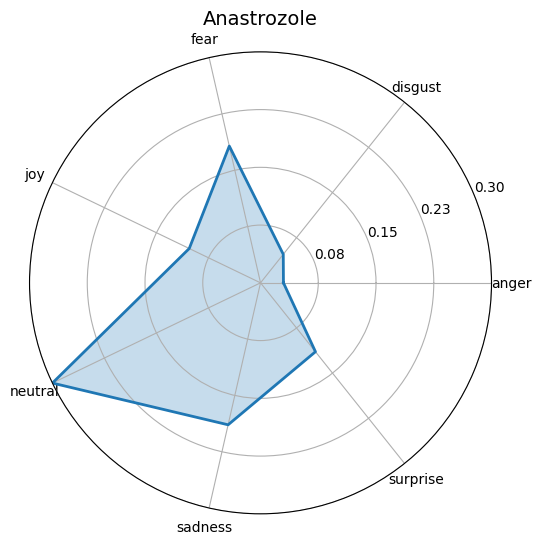

In [ ]:
drug_name="Anastrozole"
display_spider_graph_from_score(dict_drug_EmotionScore[drug_name],title=drug_name)

# AGE

### Find msg with age mention

In [75]:
pattern = re.compile(
    r"\b(?:i\s*am|i['’]m)\s*(\d{1,2})\s*(?:years?\s*old)?\b",
    flags=re.IGNORECASE
)

def get_msg_with_age_mention(dict_thread_conversation):
    list_msg_w_age=[]
    for thread_name,conversation in dict_thread_conversation.items():
        if conversation:
            try:
                messages_with_age = [
                        (msg, int(match.group(1)))
                        for msg in conversation
                        if (match := pattern.search(msg)) and int(match.group(1)) > 18
                    ]
                if messages_with_age:
                    list_msg_w_age.append(messages_with_age)
            except:
                continue
    return list_msg_w_age

In [76]:
raw_msg_w_age = get_msg_with_age_mention(dict_thread_conversation)

def get_good_format_msg_w_age(all_msg_w_bad_format):
    msg_w_age_good_format = []
    for thread in all_msg_w_bad_format:
        for msg_w_age in thread:
            msg_w_age_good_format.append(msg_w_age)
            
    return msg_w_age_good_format


In [77]:
msg_w_age = get_good_format_msg_w_age(raw_msg_w_age)

print(msg_w_age[0])

('Hey! I’m 33 going for a single nipple sparing mastectomy with expander Feb 1st. Hoping to get the other side done at a later date (they don’t want to do the prophylactic at the same time). I have IDC, scans show it to be somewhere just under 2cm but growing I’m sure. 😬 My tumor is in the axillary tail so very accessible for lumpectomy, however I am opting for mastectomy to hopefully avoid radiation. Then looks like chemo for me after...', 33)


In [78]:
def from_list_to_dict_msg_w_age(list_msg_w_age):
    age_dict = defaultdict(list)
    for msg, age in list_msg_w_age:
        age_dict[age].append(msg) 
    return dict(age_dict)


dict_msg_w_age = from_list_to_dict_msg_w_age(msg_w_age)
print(sorted(list(dict_msg_w_age.keys())))

[19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 84, 87, 88, 90, 95, 98, 99]


### Analyze emotion per age

In [79]:
dict_age_EmotionScore = get_emotion_per_features(dict_msg_w_age)

features : 33 ; num of msg : 4
features : 30 ; num of msg : 3
features : 46 ; num of msg : 11
features : 65 ; num of msg : 13
features : 20 ; num of msg : 2
features : 59 ; num of msg : 6
features : 87 ; num of msg : 1
features : 71 ; num of msg : 7
features : 66 ; num of msg : 14
features : 77 ; num of msg : 2
features : 63 ; num of msg : 9
features : 60 ; num of msg : 10
features : 47 ; num of msg : 10
features : 24 ; num of msg : 2
features : 50 ; num of msg : 13
features : 45 ; num of msg : 14
features : 84 ; num of msg : 1
features : 31 ; num of msg : 3
features : 61 ; num of msg : 7
features : 80 ; num of msg : 3
features : 52 ; num of msg : 12
features : 64 ; num of msg : 8
features : 69 ; num of msg : 5
features : 34 ; num of msg : 4
features : 67 ; num of msg : 7
features : 98 ; num of msg : 1
features : 70 ; num of msg : 10
features : 58 ; num of msg : 5
features : 40 ; num of msg : 8
features : 36 ; num of msg : 9
features : 56 ; num of msg : 10
features : 39 ; num of msg : 

age : 47 ; nbr de msg : 10


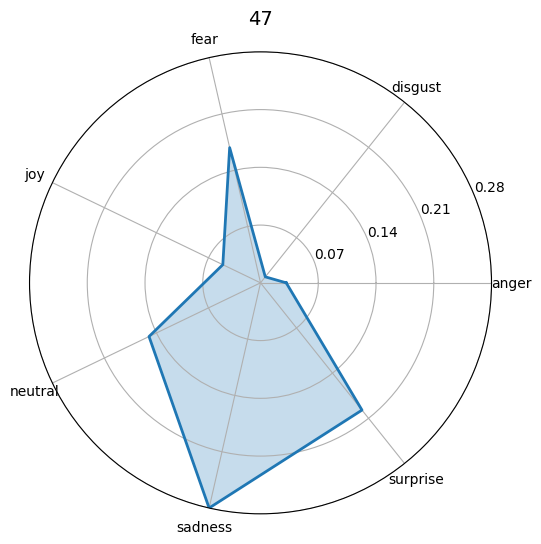

In [83]:
age=47
print(f"age : {age} ; nbr de msg : {len(dict_msg_w_age[age])}")
display_spider_graph_from_score(dict_age_EmotionScore[age],title=str(age))

### Analyze emotion per age interval

In [84]:
def avg_dicts(list_of_dicts):
    summed = defaultdict(float)
    n = len(list_of_dicts)
    
    for d in list_of_dicts:
        for key, value in d.items():
            summed[key] += value
    
    return {key: value / n for key, value in summed.items()}

def get_score_from_age_intervalle(dict_age_EmotionScore,list_age):
    list_dict_score_age = []
    for nbr,age in enumerate(list_age):
        if not age in dict_age_EmotionScore.keys():
            continue
        else:
            list_dict_score_age.append(dict_age_EmotionScore[age])
    return avg_dicts(list_dict_score_age)

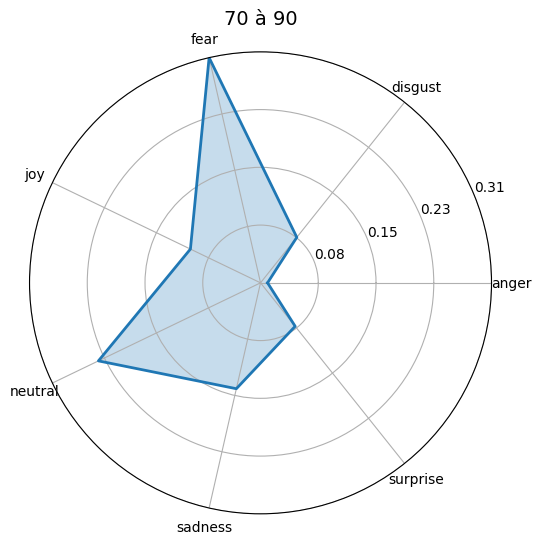

In [86]:
min_age = 70
max_age = 90
intervalle = [a for a in range(min_age,max_age)]
emotion_score_age_intervalle = get_score_from_age_intervalle(dict_age_EmotionScore,intervalle)
display_spider_graph_from_score(emotion_score_age_intervalle,title=f"{min_age} à {max_age}")

# HER2

### Find msg with HER2 mention

In [87]:
path = "../data/dict_her2.json"

with open(path, "r", encoding="utf-8") as file:
    data_her2 = json.load(file)  

print(next(iter(data_her2)))

HER2_pos


### Analyze emotion per HER2

In [88]:
dict_her_type_EmotionScore = get_emotion_per_features(data_her2)

features : HER2_pos ; num of msg : 37
features : HER2_neg ; num of msg : 95

All features get : ['HER2_pos', 'HER2_neg']


her_type : HER2_pos ; nbr de msg : 37
{'anger': 0.04185694124316797, 'disgust': 0.030474201896435557, 'fear': 0.2067975082428421, 'joy': 0.017318805662373937, 'neutral': 0.2947407389009321, 'sadness': 0.1584357627434656, 'surprise': 0.11524091046649611}


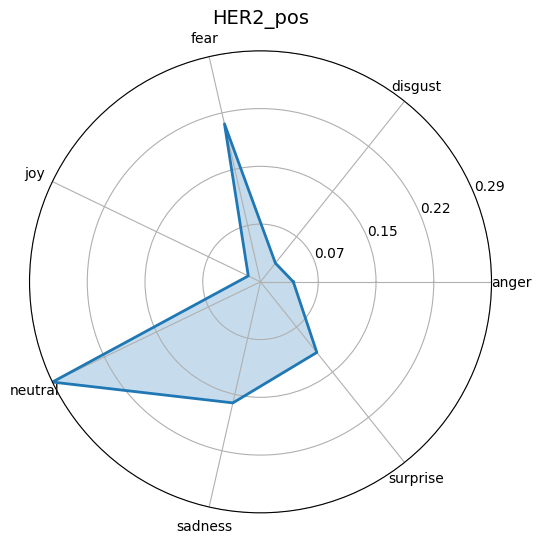

In [90]:
her_type="HER2_pos"
print(f"her_type : {her_type} ; nbr de msg : {len(data_her2[her_type])}")
print(dict_her_type_EmotionScore[her_type])
display_spider_graph_from_score(dict_her_type_EmotionScore[her_type],title=her_type)

# STAGE

### Find msg with Stage mention

In [ ]:
path = "../data/dict_stage.json"

with open(path, "r", encoding="utf-8") as file:
    data_stage = json.load(file)  

print(next(iter(data_stage)))

stage_1


### Analyze emotion per Stage

In [ ]:
dict_stage_EmotionScore = get_emotion_per_features(data_stage)

features : stage_1 ; num of msg : 28
features : stage_2 ; num of msg : 24
features : stage_3 ; num of msg : 10
features : stage_4 ; num of msg : 39

All features get : ['stage_1', 'stage_2', 'stage_3', 'stage_4']


stage : stage_4 ; num of msg : 39
{'anger': 0.019439199616989263, 'disgust': 0.03166892715335752, 'fear': 0.11437243234085588, 'joy': 0.08374215472035874, 'neutral': 0.38206703963283545, 'sadness': 0.20892287412276253, 'surprise': 0.10850531921889155}


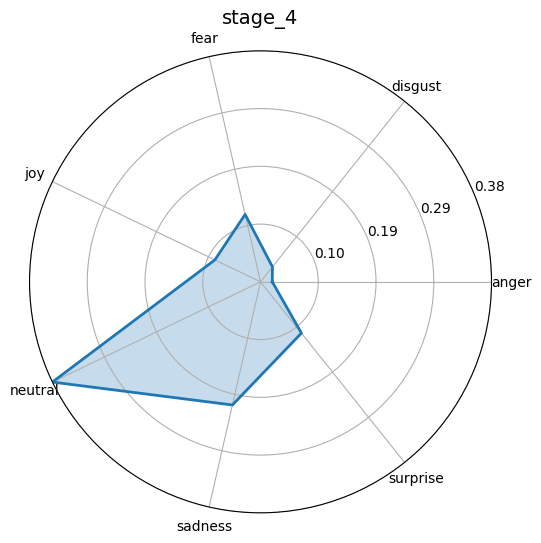

In [ ]:
stage="stage_4"
print(f"stage : {stage} ; num of msg : {len(data_stage[stage])}")
print(dict_stage_EmotionScore[stage])
display_spider_graph_from_score(dict_stage_EmotionScore[stage],title=stage)